# Serving

In [1]:
from __future__ import print_function
from PIL import Image
from grpc.beta import implementations
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2
import requests
import numpy as np
from StringIO import StringIO

In [2]:
server = 'localhost:9000'
host, port = server.split(':')

In [3]:
# define the image url to be sent to the model for prediction
image_url = "https://www.publicdomainpictures.net/pictures/60000/nahled/bird-1382034603Euc.jpg"

In [4]:
response = requests.get(image_url)
image = np.array(Image.open(StringIO(response.content)))
height = image.shape[0]
width = image.shape[1]
print("Image shape:", image.shape)

Image shape: (407, 615, 3)


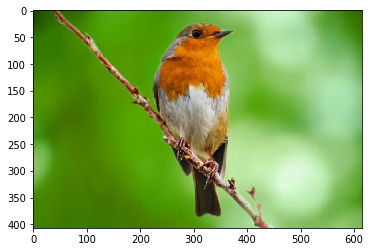

In [5]:
plt.imshow(image)
plt.show()

In [6]:
# create the RPC stub
channel = implementations.insecure_channel(host, int(port))
stub = prediction_service_pb2.beta_create_PredictionService_stub(channel)

In [7]:
# create the request object and set the name and signature_name params
request = predict_pb2.PredictRequest()
request.model_spec.name = 'deeplab'
request.model_spec.signature_name = 'predict_images'

In [8]:
# fill in the request object with the necessary data
request.inputs['images'].CopyFrom(
  tf.contrib.util.make_tensor_proto(image.astype(dtype=np.float32), shape=[1, height, width, 3]))

request.inputs['height'].CopyFrom(tf.contrib.util.make_tensor_proto(height, shape=[1]))
request.inputs['width'].CopyFrom(tf.contrib.util.make_tensor_proto(width, shape=[1]))

In [9]:
# sync requests
result_future = stub.Predict(request, 30.)

# For async requests
# result_future = stub.Predict.future(request, 10.)
# result_future = result_future.result()

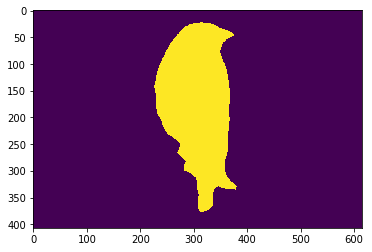

In [10]:
# get the results
output = np.array(result_future.outputs['segmentation_map'].int64_val)
height = result_future.outputs['segmentation_map'].tensor_shape.dim[1].size
width = result_future.outputs['segmentation_map'].tensor_shape.dim[2].size

image_mask = np.reshape(output, (height, width))
plt.imshow(image_mask)
plt.show()

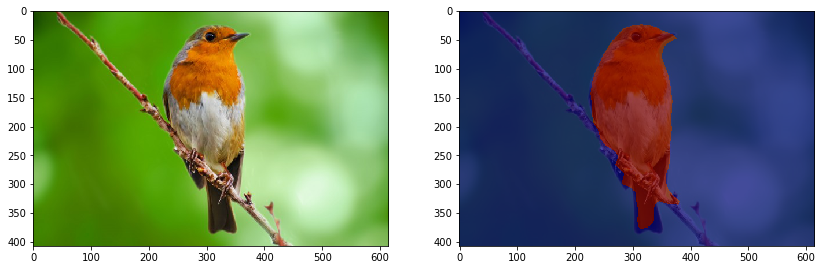

In [11]:
plt.figure(figsize=(14,10))
plt.subplot(1,2,1)
plt.imshow(image, 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(image, 'gray', interpolation='none')
plt.imshow(image_mask, 'jet', interpolation='none', alpha=0.7)
plt.show()